In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import pandas as pd

audio_path = librosa.util.example_audio_file()
y, sr = librosa.load(audio_path)
x = np.arange(0, len(y), 1)

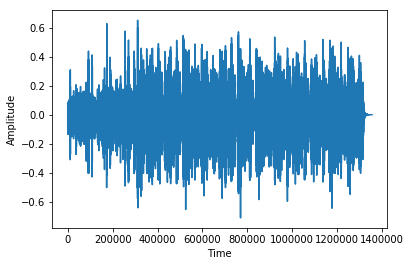

In [2]:
plt.plot(x,y)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

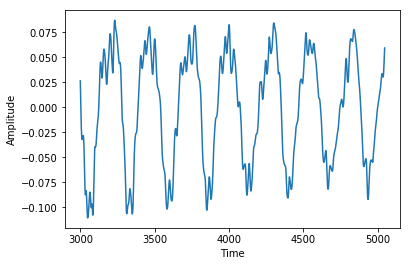

In [3]:
start_point, n_fft = 3000, 2048
plt.plot(x[start_point:start_point+n_fft], y[start_point:start_point+n_fft])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [4]:
D = np.abs(librosa.stft(y))
print(D.shape, np.max(D), np.min(D), np.mean(D))

(1025, 2647) 216.45607 5.8435834e-10 0.38008934


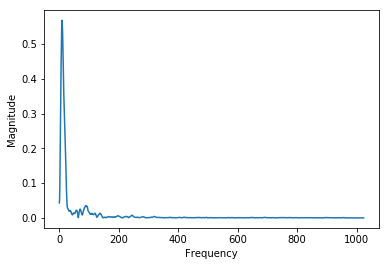

In [5]:
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
plt.plot(D[:,1])
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

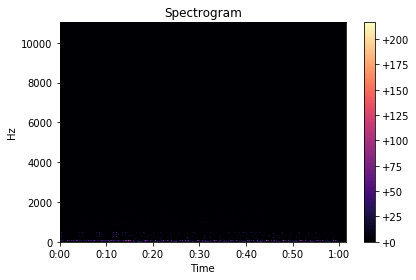

In [6]:
librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.title('Spectrogram')
plt.colorbar(format="%+2.0f")
plt.tight_layout()
plt.show()

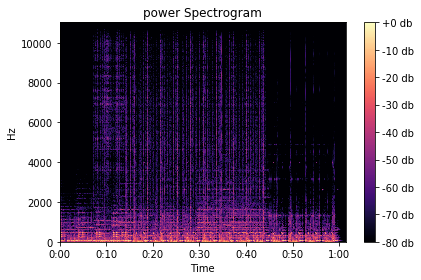

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='linear', x_axis='time')
plt.title('power Spectrogram')
plt.colorbar(format="%+2.0f db")
plt.tight_layout()
plt.show()

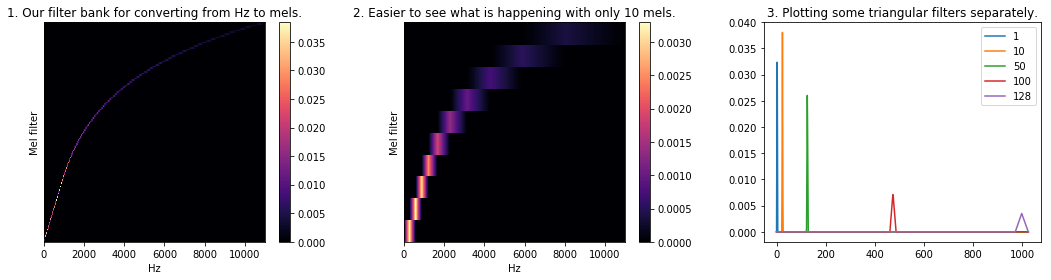

In [8]:
mel_128 = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=128)
plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
librosa.display.specshow(mel_128, sr=sr, hop_length=512, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');

plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=2048, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=512, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('2. Easier to see what is happening with only 10 mels.');

plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
	plt.plot(mel_128[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');

plt.tight_layout();

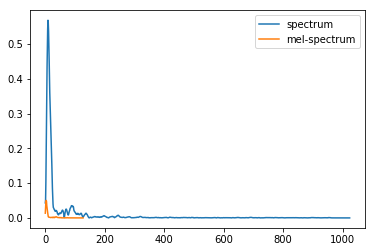

In [9]:
plt.plot(D[:,1])
plt.plot(mel_128.dot(D[:,1]))
plt.legend(labels=['spectrum', 'mel-spectrum'])
plt.show()   

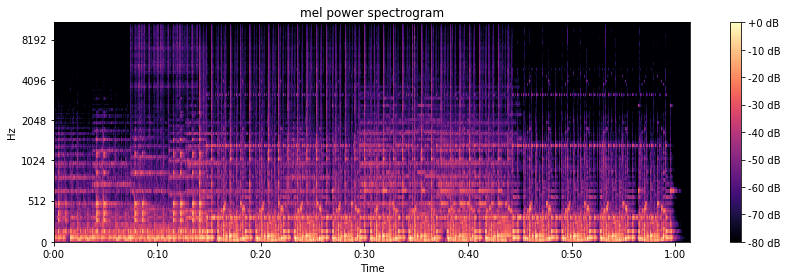

In [10]:
mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(12,4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format="%+02.0f dB")
plt.tight_layout()

In [11]:
root_dir = "./GTZAN"
csv_list = []
genres = []
for genre in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, genre)):
        genres.append(genre)
        for wav_file in os.listdir(os.path.join(root_dir, genre)):
            csv_list.append([os.path.join(root_dir, genre, wav_file), genre])
df = pd.DataFrame(csv_list, columns=['path', 'genre'])
df.to_csv(os.path.join(root_dir, "meta.csv"), index=False)

In [12]:
genre_idx_dict = dict()
g = np.array(genres)
for genre in genres:
    # genre_idx_dict[genre] = np.argwhere(g==genre)[0] # for index
    genre_idx_dict[genre] = np.array(g==genre, dtype=np.int64) # for one-hot

In [13]:
class GTZANDataset(Dataset):
    """
    GTZAN Dataset.
    """
    def __init__(self, root_dir, csv_file, sample_rate=32000, wave_size = 32000*10, n_fft=2048, hop_length=512, win_length=2048, n_mels=128, transform=None):
        """
        Args:
          csv_file (string) : GTZAN의 meta csv가 저장된 path
          transform (callable, optional) : 샘플에 적용될 optional transform
          wave_size : default wave crop size
          spec_size : default spectrogram crop size(according to time axis)
        """
        self.path_genre_dict = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sample_rate = sample_rate
        self.wav_npy_path = os.path.join(self.root_dir, 'wavs.npy')
        self.spec_npy_path = os.path.join(self.root_dir, 'specs.npy')
        self.genre_npy_path = os.path.join(self.root_dir, 'genres.npy')

        # prepare(save/load) numpy array before batch iter
        if os.path.exists(self.wav_npy_path) and os.path.exists(self.spec_npy_path) and os.path.exists(self.genre_npy_path):
            self.wavs = np.load(self.wav_npy_path)
            self.specs = np.load(self.spec_npy_path)
            self.genres = np.load(self.genre_npy_path)
        else:
            self.wavs, self.specs, self.genres = [], [], []
            for i in range(len(self.path_genre_dict)):
                wav_name, genre = self.path_genre_dict.iloc[i]
                wav, sr = librosa.load(wav_name, sr=self.sample_rate)
                genre_label = genre_idx_dict[genre]
                spec = librosa.feature.melspectrogram(y=wav[:wav_size], sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mels=n_mels)
                spec = librosa.power_to_db(spec, ref=np.max)
                self.wavs.append(wav[:wav_size])
                self.specs.append(spec)
                self.genres.append(genre_label)
            self.wavs = np.array(self.wavs)
            self.specs = np.array(self.specs)
            self.genres = np.array(self.genres)
            np.save(self.wav_npy_path, self.wavs)
            np.save(self.spec_npy_path, self.specs)
            np.save(self.genre_npy_path, self.genres)

    def __len__(self):
        return len(self.path_genre_dict)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {
            'wav' : self.wavs[idx],
            'spec' : self.specs[idx],
            'genre' : self.genres[idx],
            'sample_rate' : self.sample_rate
        }    
        if self.transform:
            sample = self.transform(sample)
        return sample

In [14]:
class RandomCrop(object):
    """
    random crop from sample data
    mode = "wav" or "spec" or "comb"
    """
    def __init__(self, wav_crop_size, spec_crop_size, mode):
        self.wav_crop_size = wav_crop_size
        self.spec_crop_size = spec_crop_size
        self.mode = mode

    def __call__(self, sample):
        """
        Assuming that the sample is wave/mel-spectrogram, crop randomly
        """
        try:
            wav, spec, genre = sample['wav'], sample['spec'], sample['genre']
            if self.mode == 'wav' or self.mode == 'comb':
                wav_len = len(wav)
                if wav_len > self.wav_crop_size:
                    start_frame = np.random.randint(0, wav_len - self.wav_crop_size)
                    wav = wav[start_frame:start_frame+self.wav_crop_size]
                elif wav_len == self.wav_crop_size:
                    pass
                else :
                    raise Exception("wave length is shorter than crop size!")

            if self.mode == 'spec' or self.mode == 'comb':
                spec_len = spec.shape[-1]
                if spec_len > self.spec_crop_size:
                    start_frame = np.random.randint(0, spec_len - self.spec_crop_size)
                    spec = spec[:, start_frame:start_frame+self.spec_crop_size]
                elif spec_len == self.spec_crop_size:
                    pass
                else:
                    raise Exception("spectrogram length is shorter than crop size!")

            return {'wav':wav, 'spec':spec, "genre":genre}

        except Exception as error:
            print("RandomCrop Transform error : " + repr(error))

In [15]:
gtzan_dataset = GTZANDataset(
    root_dir=root_dir, 
    csv_file=os.path.join(root_dir, 'meta.csv'),
    transform = transforms.Compose([
            RandomCrop(wav_crop_size = 320000, spec_crop_size = 600, mode="comb"),
        ])
    )
dataset_size = len(gtzan_dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.3 * dataset_size)) # 0.3 is test set ratio
shuffle_dataset = True
random_seed = 42
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
trn_indices, tst_indices = indices[split:], indices[:split]

trn_gtzan_dataset = torch.utils.data.sampler.SubsetRandomSampler(trn_indices)
tst_gtzan_dataset = torch.utils.data.sampler.SubsetRandomSampler(tst_indices)

trn_gtzan_dataloader = DataLoader(gtzan_dataset, batch_size = 16, drop_last=True,sampler=trn_gtzan_dataset)
val_gtzan_dataloader = DataLoader(gtzan_dataset, batch_size = 16, drop_last=True,sampler=tst_gtzan_dataset) 

In [16]:
for batch in trn_gtzan_dataloader : 
    wavs, specs, genres = batch['wav'], batch['spec'], batch['genre']
    print(wavs.shape, specs.shape, genres.shape)

torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600]) torch.Size([16, 10])
torch.Size([16, 320000]) torch.Size([16, 128, 600])